# Barrier options

**Group Members:** Alberto Maza Jr. <amaza@stevens.edu>, Gaurav Nagal <gnagal@stevens.edu>, Diyan Rahaman <drahaman@stevens.edu>, Rhea Repe <rrepe@stevens.edu>

The barrier options are path-dependent options whose payoff at maturity $T$ depends on whether or not the underlying spot price has touched some pre-defned barrier during the life of the option.

There are four main types of barrier options:

1. Up-barrier knock-in (UI), which pays $max(S(T) - K; 0)$ if the stock price reaches the barrier level $H > S_0$ during the life of the option $0 < t < T$.

2. Up-barrier knock-out (UO), which pays $max(S(T) - K; 0)$ if the stock price does not reach the barrier level $H > S_0$ during the life of the option.

3. Down-barrier knock-in barrier (DI) pays same as UI but the barrier level is below the initial stock price $H < S_0$.

4. Down-barrier knock-out (DO) pays same as UO but the barrier level is below the initial stock price $H < S_0$.

Taking $K = S_0$ (at-the-money options), the prices of the barrier options have closed form results. They can be found in the book Zhang, Peter G., 1998, Exotic Options, 2nd Edition, World Scientic Publishing, Singapore.

Using the following parameters:

* The maturity of the option is in a year’s time

* The option is struck at-the-money

* The current share price is \$100

* The risk-free continuously compounded interest rate is 8%

* The volatility for the underlying share is 30%


In [137]:
# Import necessary libraries and setup env
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import norm
%matplotlib inline

# Market information
rate = 0.08 # risk-free rate

# Share specific information
init = 100.00  # initial share price
vol  = 0.30    # volatility


Observe that the payoff of the option is dependent on the value of the share price between the inception of the option and maturity. This means that the option payoff is dependent on the history of the share price, and not just its terminal value. As a result, you will need to simulate entire share price paths to estimate the price of this option. You may make the assumptions of the Black-Sholes-Merton model (i.e. assume that the stock value follow Geometric Brownian Motion with constant drift and volatilities.) 

> $\large S_t = S_0 exp\left( \left(r - \frac{\sigma^2}{2} \right)t + \sigma\sqrt{t}Z \right)$

Build a Monte Carlo generator, assuming that the stock price follows a Black-Scholes model with continuously paid dividends. Take for simplicity $q = 0$. Compute the payoff of the barrier option along each path, checking the barrier condition at each time step. Average the payoffs over each path.

In [142]:
def barrier_option_payoff(S_0, r, sigma, T, H, option_type, steps, samples):
    '''
    Generates the option payoff for a given option type provided:
    - the initial stock price S_0
    - the risk free interest rate r
    - the stock volatility sigma
    - maturity time T
    - the barrier level H
    - option type
    - number of time steps
    - number of sample paths
    '''
    # Check for valid barrier option type
    known_types = ["UI", "UO", "DI", "DO"]
    if option_type not in known_types:
        sep = ','
        raise ValueError(f'option_type must be one of:{sep.join(known_types)}')
        
    # Generate random normal samples of size = samples x steps
    Z = norm.rvs(size = [samples, steps])
    
    t = np.linspace(T/steps, T, num=steps) # time steps
    
    # Generate stock prices for each time step for all paths
    S_t = S_0*np.exp((r - sigma**2/2)*t + sigma*np.sqrt(t)*Z)
    S_max = np.max(S_t, axis=1)            # max value of each path
    S_min = np.min(S_t, axis=1)            # min value of each path
    S_T = S_t[:,-1]                        # terminal value of each path

    if option_type is "UI":
        S = S_T * (S_max > H)
    elif option_type is "UO":
        S = S_T * (S_max < H)
    elif option_type is "DI":
        S = S_T * (S_min < H)
    elif option_type is "DO":
        S = S_T * (S_min > H)
        
    # return the discounted payoff for a call option of the given type
    return np.exp(-r*T)*np.maximum(S-K, 0)

## Up-barrier knock-in (UI)

Simulate paths for the underlying share value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.


In [143]:
# Option specific information
strike  = 100.00 # strike price (at the money)
term    = 1.0    # term of contract
barrier = 150.00 # up-and-in barrier level

np.random.seed(0)

call_est = [None]*50
call_std = [None]*50

for i in range(1, 51):
    call_val = barrier_option_payoff(init, rate, vol, term, barrier, option_type="UI", steps=12, samples=i*1000)
    call_est[i-1] = np.mean(call_val)
    call_std[i-1] = np.std(call_val)/np.sqrt(i*1000)
        

Determine analytical value of the option and compare with the Monte Carlo estimate.


We consider down-barrier call options with $H < K$ and up-barrier call options with $H > K$. All options are considered struck at the money (ATM), i.e. $K = S_0$.

Denote by $C(S,K)$ and $P(S, K)$ the Black-Scholes price of plain vanilla call and put options, respectively (the variable $r, \delta, T$ and $\sigma$ are in all instances) and let $\nu = r - \delta - \frac{\sigma^2}{2}$ and $d(S, K) = \frac{\log (S/K) + \nu T}{\sigma\sqrt{T}}$. Further, we denote by $\Phi (x)$ the standard normal cumulative distribution fucntion.



In [144]:
def d1(S, K, r, sigma, T):
    '''
    Calculate d1 given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    '''
    return (math.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))

def d2(S, K, r, sigma, T):
    '''
    Calculate d2 given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    '''
    return (math.log(S/K) + (r - sigma**2/2)*T)/(sigma*np.sqrt(T))

def C(S, K, r, sigma, T):
    '''
    Calculate the vanilla call option price given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    '''
    return S*norm.cdf(d1(S, K, r, sigma, T)) - K*np.exp(-r*T)*norm.cdf(d2(S, K, r, sigma, T))

def P(S, K, r, sigma, T):
    '''
    Calculate the vanilla put option price given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    '''
    return K*np.exp(-r*T)*norm.cdf(-d2(S, K, r, sigma, T)) - S*norm.cdf(-d1(S, K, r, sigma, T))


Using this notation, the prices of the barrier options when $H > K$ can be calculated as:

> $\large UI = \left( \frac{H}{S} \right)^\frac{2\nu}{\sigma^2} \left\{ P\left( \frac{H^2}{S}, K\right) - P\left( \frac{H^2}{S}, H\right) + \left( H - K \right) e^{-rT} \Phi\left( -d_2(H, S) \right) \right\} \\
\large + C\left( S, H \right) + \left( H - K \right) e^{-rT} \Phi\left( d_2(S,H)\right)$


In [145]:
def UI(S, K, r, sigma, T, H):
    '''
    Calculate the up-and-int barrier call option price given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    - barrier level H
    '''
    nu = r - sigma**2/2
    c1 = ((H/S)**(2*nu/sigma**2))*(P(H**2/S, K, r, sigma, T) - P(H**2/S, H, r, sigma, T) + (H-K)*np.exp(-r*T)*norm.cdf(-d2(H, S, r, sigma, T)))
    c2 = C(S, H, r, sigma, T) + (H-K)*np.exp(-r*T)*norm.cdf(d2(S, H, r, sigma, T))
    return c1+c2


Show that the Monte Carlo estimates of the barrier option call price converges with greater accuracy to that of the closed form solution as the number of simulations increase.

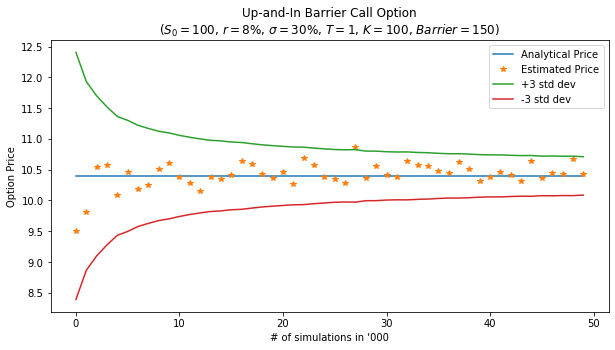

In [146]:
# Calculate the analytical call value of the barrier option
analytical_callprice = UI(init, strike, rate, vol, term, barrier)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot([analytical_callprice]*50, label="Analytical Price")
plt.plot(call_est, '*', label="Estimated Price")
plt.plot(analytical_callprice + np.array(call_std)*3, label="+3 std dev")
plt.plot(analytical_callprice - np.array(call_std)*3, label="-3 std dev")
plt.legend()
plt.xlabel("# of simulations in '000")
plt.ylabel("Option Price")
plt.title("Up-and-In Barrier Call Option\n($S_0=100$, $r=8\%$, $\sigma=30\%$, $T=1$, $K=100$, $Barrier=150$)")
plt.show()

## Up-barrier knock-out (UO)

Simulate paths for the underlying share value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.


In [147]:
# Option specific information
strike  = 100.00 # strike price
term    = 1.0    # term of contract
barrier = 150.00 # up-and-out barrier

np.random.seed(0)

call_est = [None]*50
call_std = [None]*50

for i in range(1, 51):
    call_val = barrier_option_payoff(init, rate, vol, term, barrier, option_type="UO", steps=12, samples=i*1000)
    call_est[i-1] = np.mean(call_val)
    call_std[i-1] = np.std(call_val)/np.sqrt(i*1000)
        

Using this notaion, the prices of the barrier options when $H > K$ can be calculated as:

> $\large UO = C\left( S, K \right) - C\left( S, H \right) - \left( H - K \right) e^{-rT} \Phi\left( d_2(S,H)\right) \\
\large -\left( \frac{H}{S} \right)^\frac{2\nu}{\sigma^2} \left\{ C\left( \frac{H^2}{S}, K\right) - C\left( \frac{H^2}{S}, H\right) - \left( H - K \right) e^{-rT} \Phi\left( d_2(H, S) \right) \right\}$


In [148]:
def UO(S, K, r, sigma, T, H):
    '''
    Calculate the up-and-out barrier call option price given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    - barrier level H
    '''
    nu = r - (sigma**2)/2
    c1 = C(S, K, r, sigma, T) - C(S, H, r, sigma, T) - (H-K)*np.exp(-r*T)*norm.cdf(d2(S, H, r, sigma, T))
    c2 = ((H/S)**((2*nu)/(sigma**2)))*(C(H**2/S, K, r, sigma, T) - C(H**2/S, H, r, sigma, T) - (H-K)*np.exp(-r*T)*norm.cdf(d2(H, S, r, sigma, T)))
    return c1-c2


Show that the Monte Carlo estimates of the barrier option call price converges with greater accuracy to that of the closed form solution as the number of simulations increase.

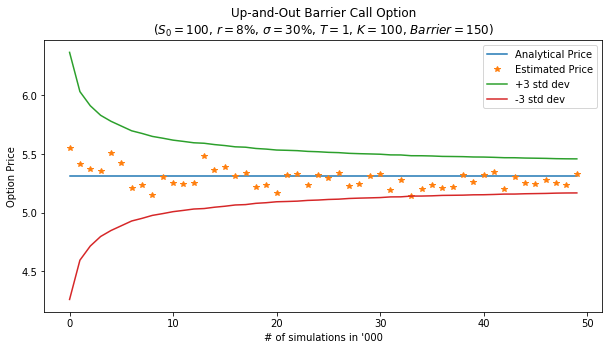

In [149]:
# Calculate the analytical call value of the barrier option
analytical_callprice = UO(init, strike, rate, vol, term, barrier)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot([analytical_callprice]*50, label="Analytical Price")
plt.plot(call_est, '*', label="Estimated Price")
plt.plot(analytical_callprice + np.array(call_std)*3, label="+3 std dev")
plt.plot(analytical_callprice - np.array(call_std)*3, label="-3 std dev")
plt.legend()
plt.xlabel("# of simulations in '000")
plt.ylabel("Option Price")
plt.title("Up-and-Out Barrier Call Option\n($S_0=100$, $r=8\%$, $\sigma=30\%$, $T=1$, $K=100$, $Barrier=150$)")
plt.show()

## Down-barrier knock-in (DI)

Simulate paths for the underlying share value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.


In [150]:
# Option specific information
strike  = 100.00 # strike price
term    = 1.0    # term of contract
barrier = 80.00  # down-and-in barrier

np.random.seed(0)

call_est = [None]*50
call_std = [None]*50

for i in range(1, 51):
    call_val = barrier_option_payoff(init, rate, vol, term, barrier, option_type="DI", steps=12, samples=i*1000)
    call_est[i-1] = np.mean(call_val)
    call_std[i-1] = np.std(call_val)/np.sqrt(i*1000)


Using this notation, the prices of the barrier options when $H < K$ can be calculated as:

> $\large DI = \left( \frac{H}{S} \right)^\frac{2\nu}{\sigma^2} C\left( \frac{H^2}{S}, K\right)$


In [151]:
def DI(S, K, r, sigma, T, H):
    '''
    Calculate the down-and-in barrier call option price given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    - barrier level H
    '''
    nu = r - (sigma**2)/2
    return ((H/S)**((2*nu)/(sigma**2)))*C(H**2/S, K, r, sigma, T)


Show that the Monte Carlo estimates of the barrier option call price converges with greater accuracy to that of the closed form solution as the number of simulations increase.

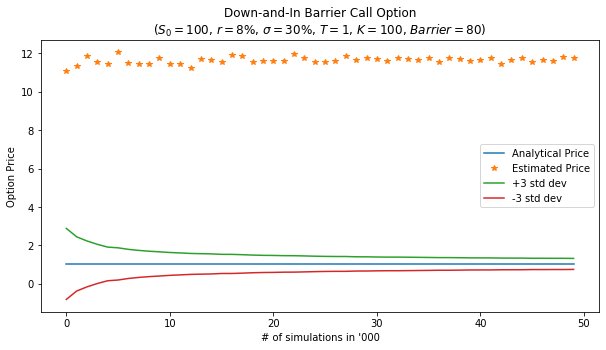

In [152]:
# Calculate the analytical call value of the barrier option
analytical_callprice = DI(init, strike, rate, vol, term, barrier)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot([analytical_callprice]*50, label="Analytical Price")
plt.plot(call_est, '*', label="Estimated Price")
plt.plot(analytical_callprice + np.array(call_std)*3, label="+3 std dev")
plt.plot(analytical_callprice - np.array(call_std)*3, label="-3 std dev")
plt.legend()
plt.xlabel("# of simulations in '000")
plt.ylabel("Option Price")
plt.title("Down-and-In Barrier Call Option\n($S_0=100$, $r=8\%$, $\sigma=30\%$, $T=1$, $K=100$, $Barrier=80$)")
plt.show()

## Down-barrier knock-out (DO)

Simulate paths for the underlying share value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.


In [153]:
# Option specific information
strike  = 100.00 # strike price
term    = 1.0    # term of contract
barrier = 80.00  # down-and-out barrier

np.random.seed(0)

call_est = [None]*50
call_std = [None]*50

for i in range(1, 51):
    call_val = barrier_option_payoff(init, rate, vol, term, barrier, option_type="DO", steps=12, samples=i*1000)
    call_est[i-1] = np.mean(call_val)
    call_std[i-1] = np.std(call_val)/np.sqrt(i*1000)


Using this notation, the prices of the barrier options when $H < K$ can be calculated as:

> $\large DO = C\left( S, K \right) - \left( \frac{H}{S} \right)^\frac{2\nu}{\sigma^2} C\left( \frac{H^2}{S}, K\right)$


In [154]:
def DO(S, K, r, sigma, T, H):
    '''
    Calculate the down-and-out barrier call option price given:
    - stock price S
    - strike price K
    - risk free interest rate r
    - stock volatility sigma
    - time to maturity T
    - barrier level H
    '''
    nu = r - (sigma**2)/2
    return C(S, K, r, sigma, T) - ((H/S)**((2*nu)/(sigma**2)))*C(H**2/S, K, r, sigma, T)


Show that the Monte Carlo estimates of the barrier option call price converges with greater accuracy to that of the closed form solution as the number of simulations increase.

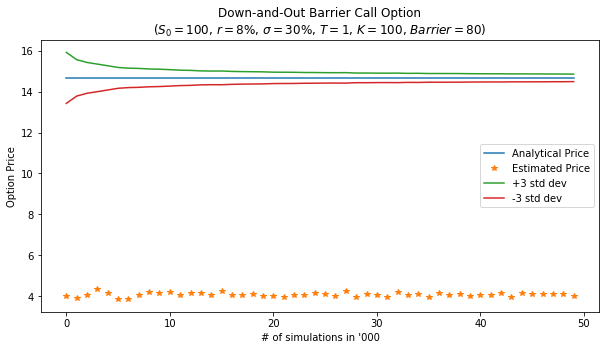

In [155]:
# Calculate the analytical call value of the barrier option
analytical_callprice = DO(init, strike, rate, vol, term, barrier)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot([analytical_callprice]*50, label="Analytical Price")
plt.plot(call_est, '*', label="Estimated Price")
plt.plot(analytical_callprice + np.array(call_std)*3, label="+3 std dev")
plt.plot(analytical_callprice - np.array(call_std)*3, label="-3 std dev")
plt.legend()
plt.xlabel("# of simulations in '000")
plt.ylabel("Option Price")
plt.title("Down-and-Out Barrier Call Option\n($S_0=100$, $r=8\%$, $\sigma=30\%$, $T=1$, $K=100$, $Barrier=80$)")
plt.show()

# Limiting Cases

Test the pricer on limiting cases, e.g. as the barrier is very large, the price of the knock-out option should approach the Black-Scholes price, and the price of the knock-in
option should go to zero.

In [156]:
# Option specific information
strike  = 100.00  # strike price
term    = 1.0     # term of contract
barrier = np.linspace(110, 500, num=40)  # barrier values: 110, 120, 130, ..., 500

np.random.seed(0)

UO_est = [None]*40
UI_est = [None]*40
UP_est = [None]*40

# Simulate UO and UI barrier option prices
for i in range(40):
    UO_val = barrier_option_payoff(init, rate, vol, term, barrier[i], option_type="UO", steps=12, samples=100000)
    UO_est[i] = np.mean(UO_val)
    UI_val = barrier_option_payoff(init, rate, vol, term, barrier[i], option_type="UI", steps=12, samples=100000)
    UI_est[i] = np.mean(UI_val)
    UP_est[i] = np.mean(UO_val + UI_val)


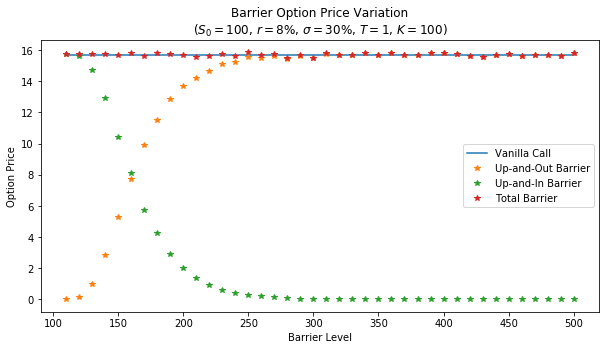

In [157]:
# Calculate the analytical call value of a vanilla option
analytical_callprice = C(init, strike, rate, vol, term)

# Plotting the graph
plt.figure(figsize=(10,5))
plt.plot(barrier, [analytical_callprice]*40, label="Vanilla Call" )
plt.plot(barrier, UO_est, '*', label="Up-and-Out Barrier")
plt.plot(barrier, UI_est, '*', label="Up-and-In Barrier")
plt.plot(barrier, UP_est, '*', label="Total Barrier")
plt.legend()
plt.xlabel("Barrier Level")
plt.ylabel("Option Price")
plt.title("Barrier Option Price Variation\n($S_0=100$, $r=8\%$, $\sigma=30\%$, $T=1$, $K=100$)")
plt.show()

# Conclusion

We have used a simple stock process to model the evolution of the stock price assuming constant interest rate and normally distributed returns. We then simulated the different types of barrier options - up-and-in (UI), up-and-out (UO), down-and-in (DI), down-and-out (DO) - by generating the stock prices for 50,000 paths in increments of 10,000. The average call price and standard deviations of these call prices were then plotted against the closed form solutions from [1] to show that the estimated prices converge to the analytical price for a given accuracy provided we can emulate a large number of paths.

# Bibliography

[1] Zhang, Peter G., 1998, Exotic Options, 2nd Edition, World Scientic Publishing, Singapore.
